In [441]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

df = pd.read_csv('CASE_2.csv')



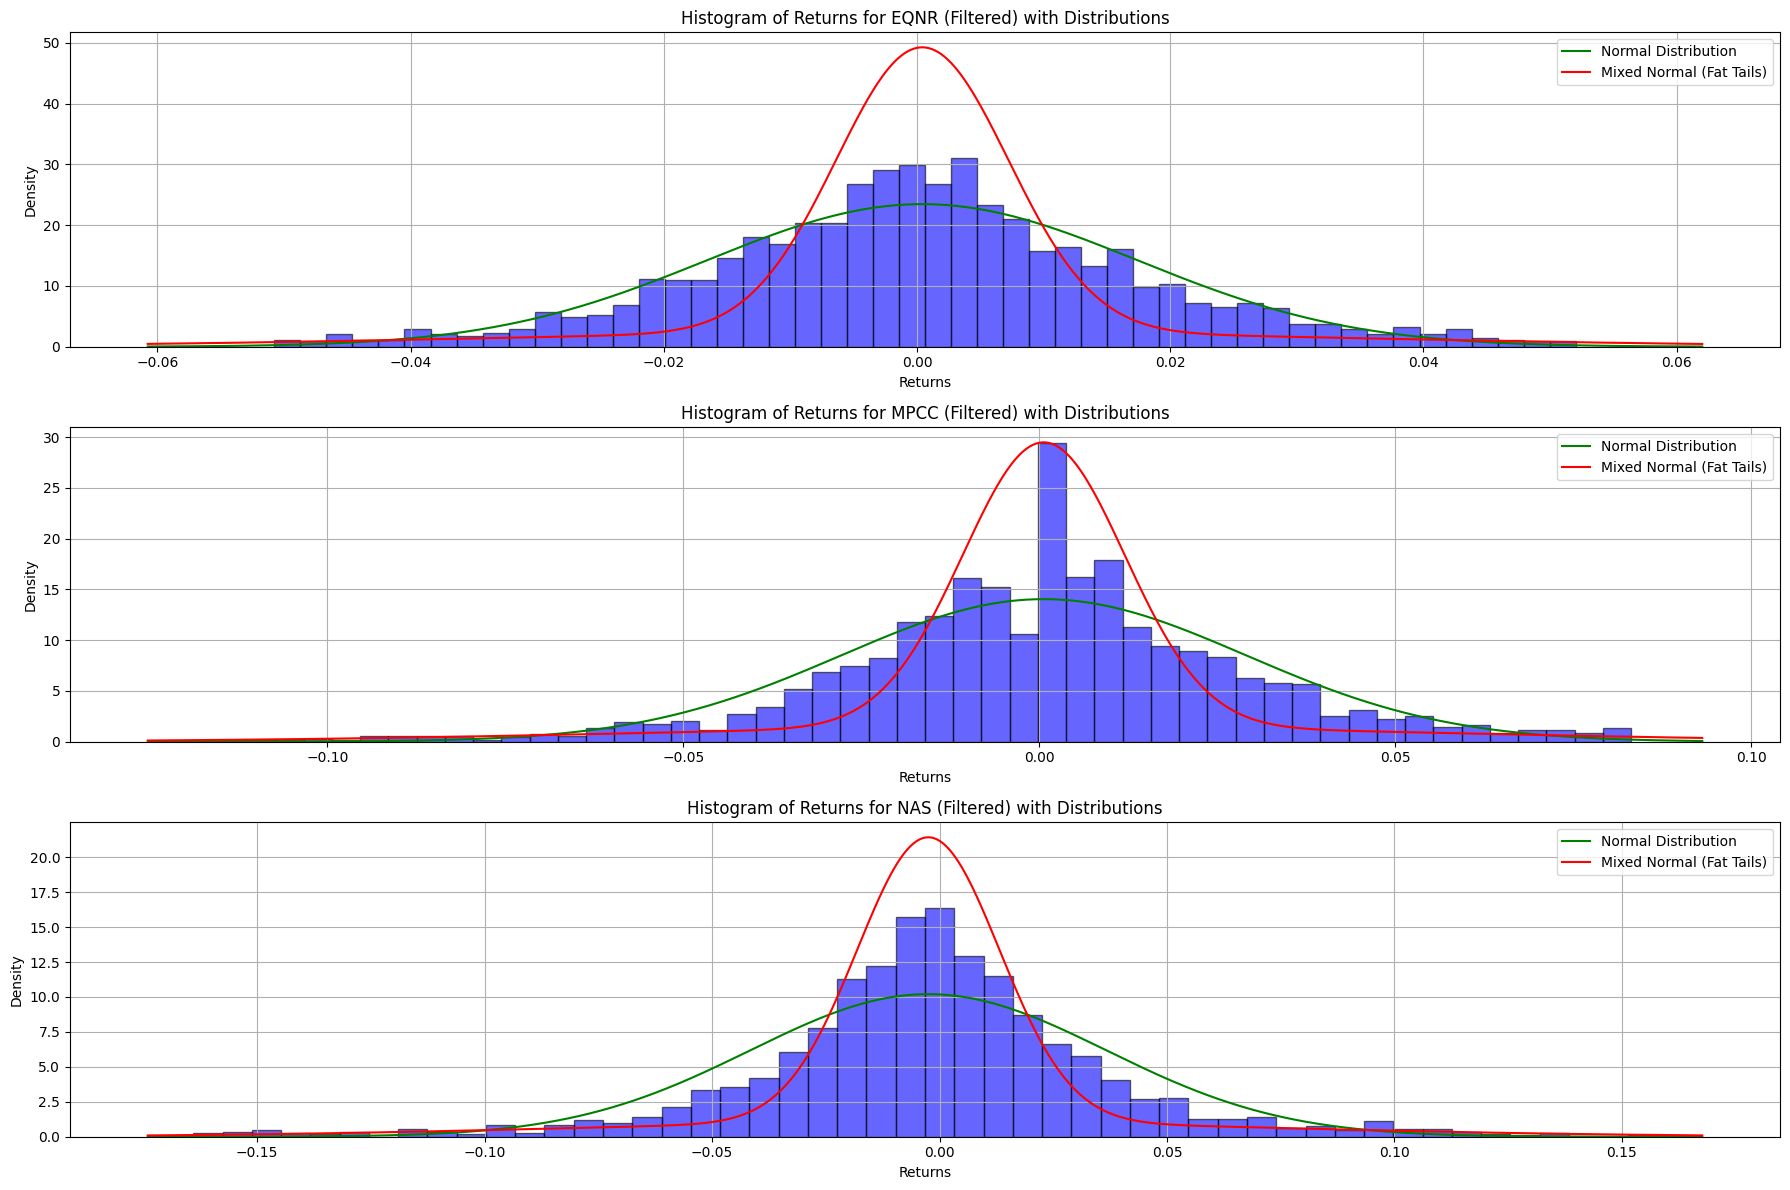

In [442]:
# Loop through stocks to clean and visualize returns


stocks = df['Symbol'].unique()
plt.figure(figsize=(18, 12))

for i, stock in enumerate(stocks, 1):
    # Filter data for the specific stock
    stock_df = df[df['Symbol'] == stock].copy()
    stock_df['Returns'] = stock_df['Price'].pct_change()
    returns = stock_df['Returns'].dropna()

    # Dynamically calculate thresholds for filtering extreme outliers
    lower_bound, upper_bound = returns.quantile(0.01), returns.quantile(0.99)
    filtered_returns = returns[(returns >= lower_bound) & (returns <= upper_bound)]

    # Update the range for x-values based on the filtered data
    x_vals = np.linspace(filtered_returns.min() - 0.01, filtered_returns.max() + 0.01, 1000)

    # Calculate mean and standard deviation
    rmean = filtered_returns.mean()
    rstd = filtered_returns.std()

    # Calculate distributions
    norm_dist = norm.pdf(x_vals, loc=rmean, scale=rstd)
    fat_tails = (0.8 * norm.pdf(x_vals, loc=rmean, scale=rstd * 0.4) +
                 0.2 * norm.pdf(x_vals, loc=rmean, scale=rstd * 2))

    # Create subplot for each stock
    plt.subplot(3, 1, i)
    count, bins, ignored = plt.hist(filtered_returns, bins=50, density=True, alpha=0.6, color='blue', edgecolor='k')

    # Plot normal and mixed normal distributions
    plt.plot(x_vals, norm_dist, label="Normal Distribution", color='green')
    plt.plot(x_vals, fat_tails, label="Mixed Normal (Fat Tails)", color='red')

    # Set titles and labels
    plt.title(f'Histogram of Returns for {stock} (Filtered) with Distributions')
    plt.xlabel('Returns')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


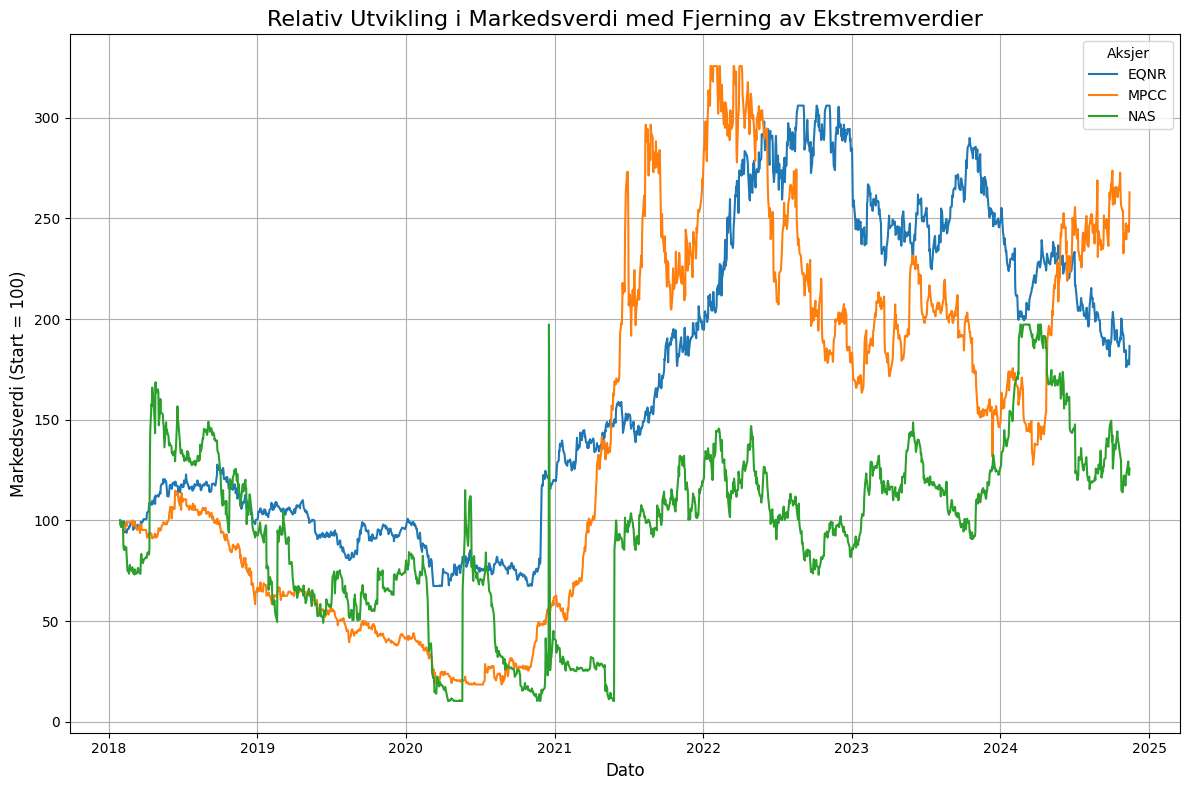

In [443]:
# Sørg for at Date-kolonnen er i datetime-format
df['Date'] = pd.to_datetime(df['Date'])

# Pivot data for mktcap
pivot_df = df.pivot_table(index='Date', columns='Symbol', values='mktcap', aggfunc='sum')

# --- Fjerning av ekstremverdier ---
filtered_df = pivot_df.copy()
for stock in filtered_df.columns:
    lower_bound, upper_bound = filtered_df[stock].quantile(0.01), filtered_df[stock].quantile(0.99)
    filtered_df[stock] = filtered_df[stock].clip(lower=lower_bound, upper=upper_bound)

# --- Normalisering ---
normalized_df = filtered_df.div(filtered_df.iloc[0]).mul(100)

# --- Plotting ---
plt.figure(figsize=(12, 8))
for stock in normalized_df.columns:
    plt.plot(normalized_df.index, normalized_df[stock], label=stock)

# Legg til tittel, akser og legende
plt.title('Relativ Utvikling i Markedsverdi med Fjerning av Ekstremverdier', fontsize=16)
plt.xlabel('Dato', fontsize=12)
plt.ylabel('Markedsverdi (Start = 100)', fontsize=12)
plt.legend(title="Aksjer", fontsize=10)
plt.grid(True)
plt.tight_layout()

# Vis grafen
plt.show()


In [444]:
# Standardiser navn i kolonnen "Name"
df['Name'] = df['Name'].str.upper().str.strip()

# Erstatt spesifikke navn
df['Name'] = df['Name'].replace({
    "MPC CONTAINER SHIPS": "MPC CONTAINER SHIP",  # Standardiser MPC Container Ships
    "NORWEGIAN AIR SHUT": "NORWEGIAN AIR SHUTTLE"  # Standardiser Norwegian Air Shuttle
})



In [445]:
print(df['Name'].unique())


['EQUINOR' 'MPC CONTAINER SHIP' 'NORWEGIAN AIR SHUTTLE']


In [446]:


# Definer årlig risikofri rente 
rf = df['NOWA_DayLnrate'].mean() * 7

# Finn ISIN-er som er tilgjengelige både på første og siste dato
isin_with_first_date = df[df['Date'] == df['Date'].min()]['ISIN'].unique()
isin_with_last_date = df[df['Date'] == df['Date'].max()]['ISIN'].unique()
valid_isins = set(isin_with_first_date).intersection(isin_with_last_date)

# Behold kun data for disse ISIN-ene
df = df[df['ISIN'].isin(valid_isins)]

# Opprett en ny kolonne som kombinerer Name og ISIN
df['Name (ISIN)'] = df['Name'].str.upper().str.strip() + '(' + df['ISIN'] + ')'

# Behold kun de mest omsatte aksjene (basert på Turnover)
res = (
    df.groupby(['Name (ISIN)'])
    .agg({'Turnover': 'sum'})  # Summer total omsetning for hver aksje
    .sort_values(by='Turnover', ascending=False)  # Sorter etter Turnover
)

# Slå sammen DataFrame 
df = df.merge(res.head(3), on=['Name (ISIN)'], how='inner')

# Sjekk resultatet
print(res.head())


                                         Turnover
Name (ISIN)                                      
EQUINOR(NO0010096985)                1.363650e+12
NORWEGIAN AIR SHUTTLE(NO0010196140)  1.529267e+11
MPC CONTAINER SHIP(NO0010791353)     7.566410e+10


In [447]:
def get_matrix(df, field):
    """Converts the df to a matrix df that can 
    be used to calculate the covariance matrix"""
    
    import pandas as pd
    df['Date'] = pd.to_datetime(df['Date'])
    df_unique = df.drop_duplicates(
                                    subset=['Date', 'ISIN'])
    pivot_df = df_unique.pivot(index='Date', 
                                    columns='Symbol', 
                                    values=field)

    pivot_df = pivot_df.dropna()

    # Annualized weekly returns
    df_weekly = pivot_df.resample('W').sum()

    return df_weekly

#X is a matrxi with e
X_df = get_matrix(df, 'lnDeltaP') 
X_df = X_df.sort_index()

X_df

Symbol,EQNR,MPCC,NAS
Date,,,
2018-02-04,-0.029028,-0.009569,-0.002572
2018-02-11,-0.022192,-0.039221,-0.135372
2018-02-18,0.016373,0.039221,-0.150880
2018-02-25,0.030582,0.000000,0.017840
2018-03-04,-0.034006,-0.019418,-0.032809
...,...,...,...
2024-10-20,-0.040427,-0.006634,0.013834
2024-10-27,0.071878,-0.030408,-0.186962
2024-11-03,-0.087204,-0.054186,0.059715


In [448]:
# Converting X to a numpy array:
X = np.array(X_df)

# Calculating the covariance
cov_matrix = np.cov(X, rowvar=False)

# Calculating the means vector, and reshaping it to a 
# column vector. 

means = np.mean(X, axis=0).reshape((X.shape[1],1))


In [449]:
ones = np.ones((len(means),1))

A = (ones.T @ np.linalg.inv(cov_matrix) @ ones)[0][0]

B = (ones.T @ np.linalg.inv(cov_matrix) 
                                @ (means-rf))[0][0]

C = ((means.T-rf) @ np.linalg.inv(cov_matrix) 
                                @ (means-rf))[0][0]

print(A)
print(B)
print(C)

677.9349618396983
0.14582566012534381
0.02269750832154529


In [450]:
def portfolio_front(expected_excess_return, a, b, c):
    r = expected_excess_return
    minimum_variance = (1/a 
            + ((r - abs(b)/a)**2) / (c - b**2/a))
    minimum_volatility = minimum_variance**0.5
    return minimum_volatility

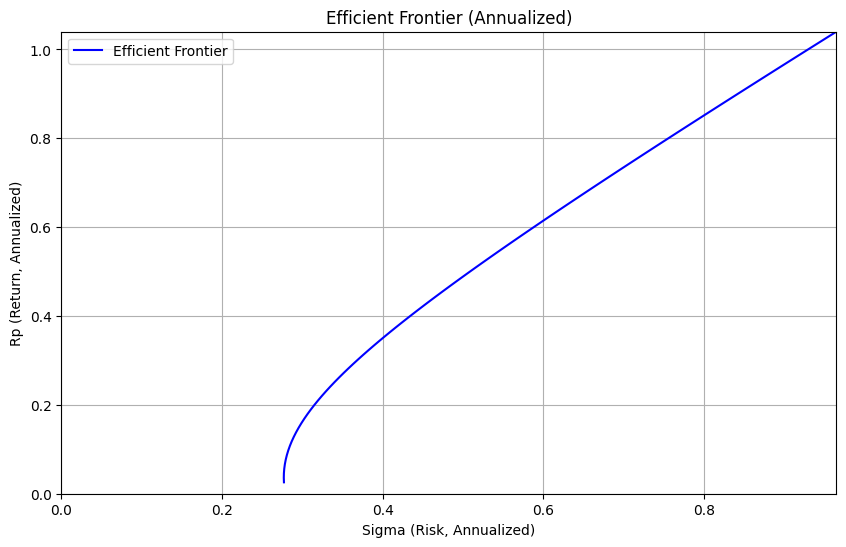

In [451]:
from matplotlib import pyplot as plt
#Creating plot
fig, ax = plt.subplots(figsize=(10, 6))
plot_scale = 52
MAX_AXIS = 0.02
#applying the function

rp_values = np.linspace(0, MAX_AXIS-rf, 100)
sigma_values = portfolio_front(rp_values, A, B, C) * plot_scale**0.5
rp_values_annualized = (rp_values + rf) * plot_scale



ax.plot(sigma_values, rp_values_annualized, label='Efficient Frontier', color='blue')

# Plot-innstillinger
ax.set_xlim([0, np.max(sigma_values)])
ax.set_ylim([0, np.max(rp_values_annualized)])
ax.set_xlabel('Sigma (Risk, Annualized)')
ax.set_ylabel('Rp (Return, Annualized)')
ax.set_title('Efficient Frontier (Annualized)')
ax.legend()
ax.grid(True)
plt.show()




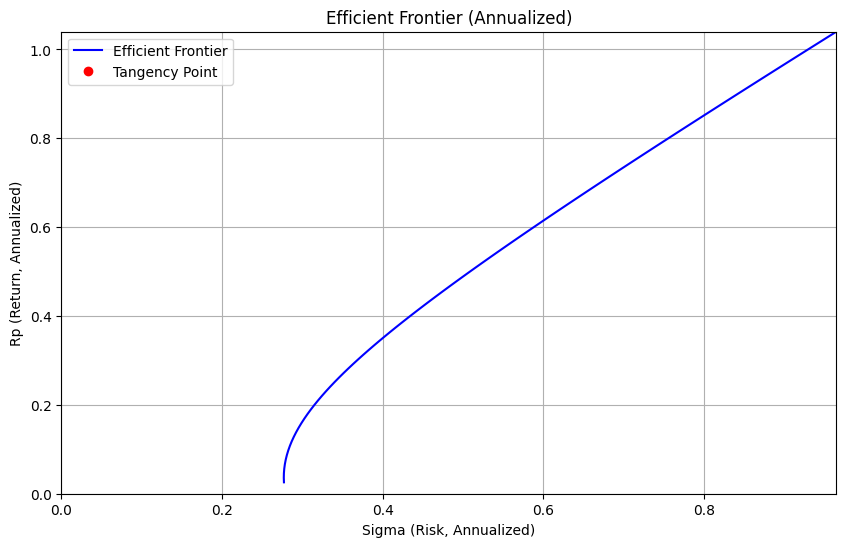

In [452]:
# Calculating the tangency point of the normalized 
# optimal portfolio
tangency_sigma =  portfolio_front(C/B, A, B, C)

#plotting it, after annualizing the weekly data
ax.plot(plot_scale**0.5*tangency_sigma, 
                    plot_scale*(C/B + rf), 
                    'ro',label='Tangency Point')
ax.legend()
fig

In [453]:
# Kontroll av beregninger
print("A:", A)
print("B:", B)
print("C:", C)

print("C / B (risikojustert avkastning, ukentlig):", C / B)

print("Risikofri rente (ukentlig):", rf)


A: 677.9349618396983
B: 0.14582566012534381
C: 0.02269750832154529
C / B (risikojustert avkastning, ukentlig): 0.15564824669427688
Risikofri rente (ukentlig): 0.0004938091720148648


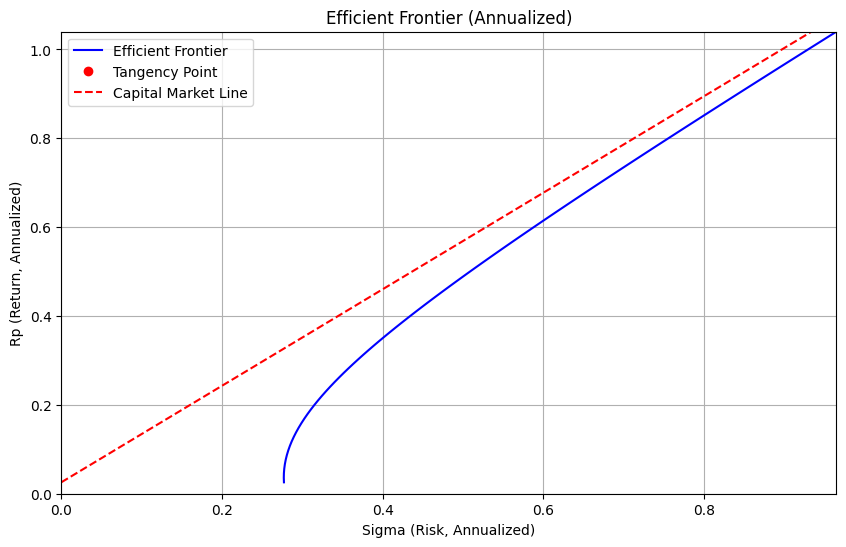

In [454]:

sigma_range = np.linspace(0, np.max(sigma_values), 100)

# Plotting the portfolio front, after annualizing the 
# weekly data
ax.plot(plot_scale**0.5*sigma_range, plot_scale*(rf 
                + sigma_range*(C/B)/tangency_sigma), 
                color='r', linestyle='--', 
                label='Capital Market Line')

ax.legend()

fig

In [455]:
#Calculating the normalized optimal portfolio
opt_port = np.linalg.inv(cov_matrix) @ (means-rf)/B

#Calculating the returns of the optimal portfolio:
X_df['Optimal'] = X @ opt_port

#Saving the dataframe for later use:
pd.to_pickle(X_df, 'output/X.df')

# inserting the portfolio into a data frame for display
d = {}
for i in range(len(opt_port)):
    d[X_df.columns[i]] = [f"{np.round(opt_port[i][0]*100,0)}%"]

print("Hence the optimal portfolio in this case is")
pd.DataFrame(d)


Hence the optimal portfolio in this case is


,EQNR,MPCC,NAS
0,874.0%,-7.0%,-768.0%


In [456]:
# Normalisere vektene slik at de summerer til 100%
opt_port_normalized = opt_port / np.sum(np.abs(opt_port))
d_normalized = {}
for i in range(len(opt_port_normalized)):
    d_normalized[X_df.columns[i]] = [f"{np.round(opt_port_normalized[i][0] * 100, 2)}%"]

print("Optimal portefølje med normaliserte vekter:")
print(pd.DataFrame(d_normalized))


Optimal portefølje med normaliserte vekter:
     EQNR   MPCC      NAS
0  53.03%  -0.4%  -46.57%


In [457]:
import pandas as pd
df = pd.read_pickle('output/X.df')
df

Symbol,EQNR,MPCC,NAS,Optimal
Date,,,,
2018-02-04,-0.029028,-0.009569,-0.002572,-0.233460
2018-02-11,-0.022192,-0.039221,-0.135372,0.848031
2018-02-18,0.016373,0.039221,-0.150880,1.299191
2018-02-25,0.030582,0.000000,0.017840,0.130436
2018-03-04,-0.034006,-0.019418,-0.032809,-0.044163
...,...,...,...,...
2024-10-20,-0.040427,-0.006634,0.013834,-0.459310
2024-10-27,0.071878,-0.030408,-0.186962,2.066224
2024-11-03,-0.087204,-0.054186,0.059715,-1.217558


In [458]:
def generate_backtest(f, df, name, estimation_win_size):
    # Initialize lists to store calculated values
    datelist = []
    sigmalist = []
    d95list = []
    d99list = []
    ret = []

    # Iterate over returns to calculate and store VaR and volatility estimates
    for t in range(estimation_win_size, len(df)):
        
        # Record date and current return
        datelist.append(df.index[t].date())
        ret.append(df[name].iloc[t])

        # Extract data from the estimation window (t-estimation_win_size to t-1)
        x = df[name].iloc[t-estimation_win_size:t-1]

        # Apply the provided VaR estimation function using the historical data and past volatility
        d95, d99, sigma = f(x, sigmalist)

        # Append the estimates to their respective lists
        sigmalist.append(sigma)
        d95list.append(d95)
        d99list.append(d99)

    # Return the results as numpy arrays for ease of analysis
    return (np.array(d95list),
            np.array(d99list),
            np.array(sigmalist),
            np.array(datelist),
            np.array(ret))

In [459]:
import matplotlib.pyplot as plt
def evaluate(plt, d95, d99, ret, dates, heading):
    # Clear the plot area to avoid overlapping plots
    plt.cla()

    # Plot the 95% VaR, 99% VaR, and actual returns
    plt.plot(dates, d95, label='95% Confidence Level')
    plt.plot(dates, d99, label='99% Confidence Level')
    plt.plot(dates, ret, label='Actual Return')

    # Highlight instances where returns breach the 95% VaR
    maxret = max(ret)
    breaches_95 = [maxret if d > r else 0 for d, r in zip(d95, ret)]
    plt.bar(dates, breaches_95, color='gray', alpha=0.5, width=0.5, label='Breaches 95% VaR')

    # Set labels and title
    plt.ylabel('VaR')
    plt.xlabel('Date')
    plt.title(heading)
    plt.xticks(rotation=90)
    plt.legend(loc="lower right")
    plt.subplots_adjust(bottom=0.15)
    plt.show()

    # Calculate and print the breach percentage for each confidence level
    backtest_results = [np.round(sum(d > ret) / len(ret) * 100, 1) for d in [d95, d99]]

    for i, level in enumerate([95, 99]):
        breaches = sum([d95, d99][i] > ret)
        print(f"{heading} with {level}% confidence interval:\n"
              f"Breaches: {breaches}\n"
              f"Backtesting (Realized VaR - % breaches): {backtest_results[i]}%\n")

In [460]:
PVALS = [0.05, 0.01]  # Confidence intervals (95% and 99%)
from scipy.stats import norm

def normal_est(x, sigmalist):
    z = norm.ppf(PVALS)  # Z-scores for the specified confidence levels
    sigma = np.std(x, ddof=1)  # Sample standard deviation
    return z[0] * sigma, z[1] * sigma, sigma

In [461]:
def historical_est(x, sigmalist):
    q95 = abs(np.quantile(x, PVALS[0]))  # 95th percentile of historical losses
    q99 = abs(np.quantile(x, PVALS[1]))  # 99th percentile of historical losses
    return -q95, -q99, None  # VaR values are negative to indicate potential loss

In [462]:
def last_volat(x, sigmalist):
    x = np.array(x)
    z = norm.ppf(PVALS)
    if not sigmalist:  # If sigmalist is empty, use initial standard deviation
        sigma = np.std(x, ddof=1)
    else:  # Update sigma based on past volatility and recent error
        sigma = (0.1 * (x[0] - np.mean(x))**2 + 0.9 * sigmalist[-1]**2)**0.5
    return z[0] * sigma, z[1] * sigma, sigma

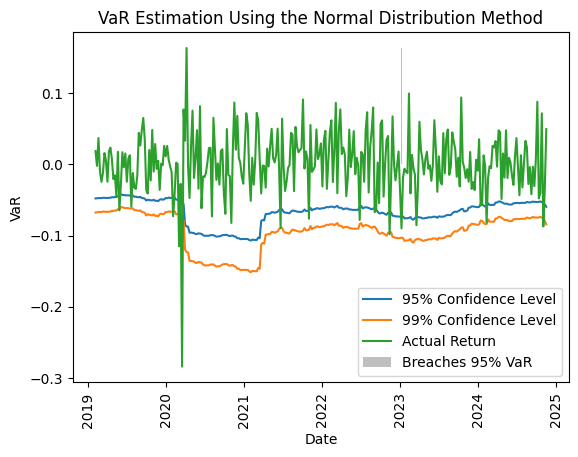

VaR Estimation Using the Normal Distribution Method with 95% confidence interval:
Breaches: 16
Backtesting (Realized VaR - % breaches): 5.3%

VaR Estimation Using the Normal Distribution Method with 99% confidence interval:
Breaches: 7
Backtesting (Realized VaR - % breaches): 2.3%



In [463]:
NAME = 'EQNR'
ESTIMATION_WINSIZE = 52

(normal95, normal99, 
 sigma, dates, ret )= generate_backtest(normal_est, 
        df, NAME, ESTIMATION_WINSIZE)
evaluate(plt, normal95, normal99, ret, dates,
         'VaR Estimation Using the Normal Distribution Method')

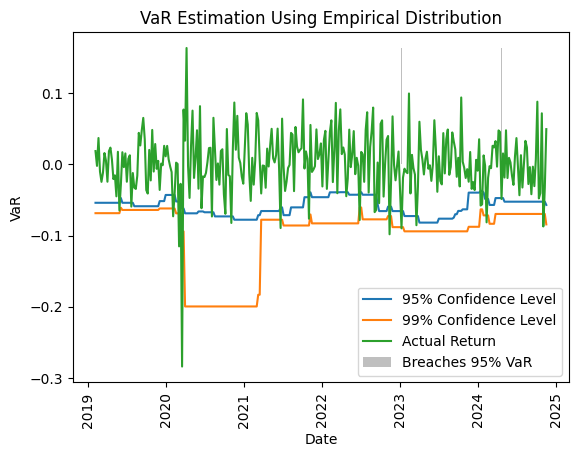

VaR Estimation Using Empirical Distribution with 95% confidence interval:
Breaches: 22
Backtesting (Realized VaR - % breaches): 7.3%

VaR Estimation Using Empirical Distribution with 99% confidence interval:
Breaches: 9
Backtesting (Realized VaR - % breaches): 3.0%



In [464]:
(hist95, hist99, 
 sigma, dates, ret )= generate_backtest(historical_est, 
        df, NAME, ESTIMATION_WINSIZE)
evaluate(plt, hist95, hist99, ret, dates,
         'VaR Estimation Using Empirical Distribution')

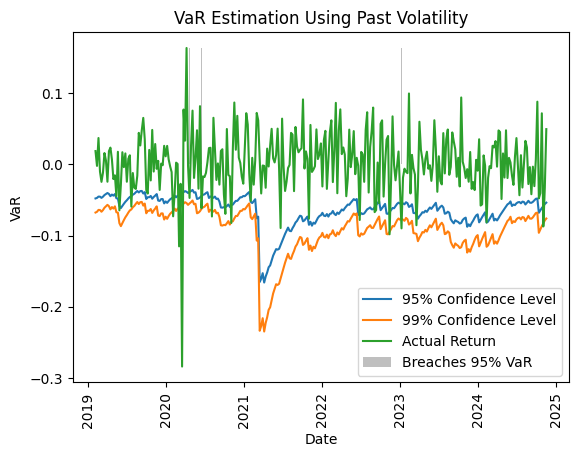

VaR Estimation Using Past Volatility with 95% confidence interval:
Breaches: 18
Backtesting (Realized VaR - % breaches): 5.9%

VaR Estimation Using Past Volatility with 99% confidence interval:
Breaches: 8
Backtesting (Realized VaR - % breaches): 2.6%



In [465]:
(last95, last99, 
 sigma, dates, ret )= generate_backtest(last_volat, 
        df, NAME, ESTIMATION_WINSIZE)
evaluate(plt, last95, last99, ret, dates,
         'VaR Estimation Using Past Volatility')


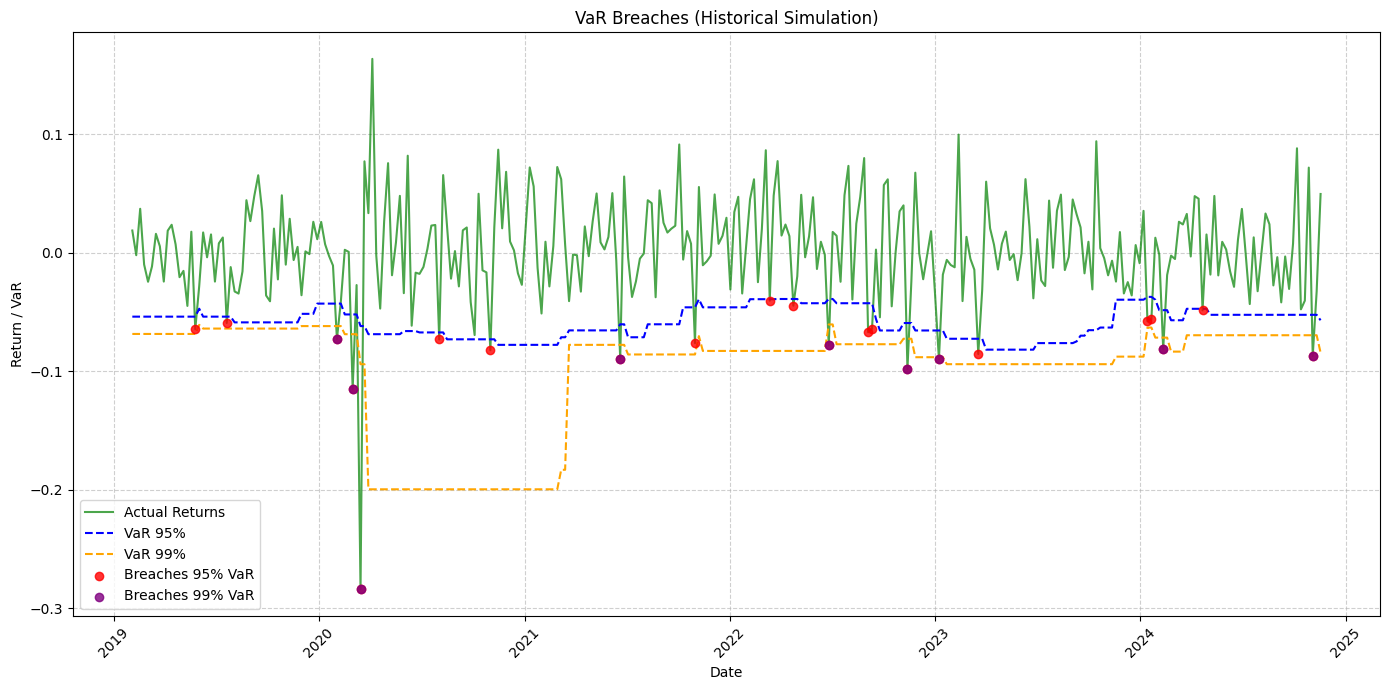

In [466]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_breaches(dates, ret, var95, var99, title):
   
    # Initialize the plot
    plt.figure(figsize=(14, 7))
    
    # Plot actual returns
    plt.plot(dates, ret, label='Actual Returns', color='green', alpha=0.7)
    
    # Plot VaR thresholds
    plt.plot(dates, var95, label='VaR 95%', color='blue', linestyle='--')
    plt.plot(dates, var99, label='VaR 99%', color='orange', linestyle='--')
    
    # Highlight breaches
    breaches_95 = [r if r < v else np.nan for r, v in zip(ret, var95)]
    breaches_99 = [r if r < v else np.nan for r, v in zip(ret, var99)]
    
    plt.scatter(dates, breaches_95, color='red', label='Breaches 95% VaR', alpha=0.8, zorder=5)
    plt.scatter(dates, breaches_99, color='purple', label='Breaches 99% VaR', alpha=0.8, zorder=5)
    
    # Add grid, legend, and titles
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Return / VaR')
    plt.legend(loc='lower left')
    
    # Format x-axis for better readability
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Show the plot
    plt.show()

# Example call with your data
visualize_breaches(dates, ret, hist95, hist99, 'VaR Breaches (Historical Simulation)')



 

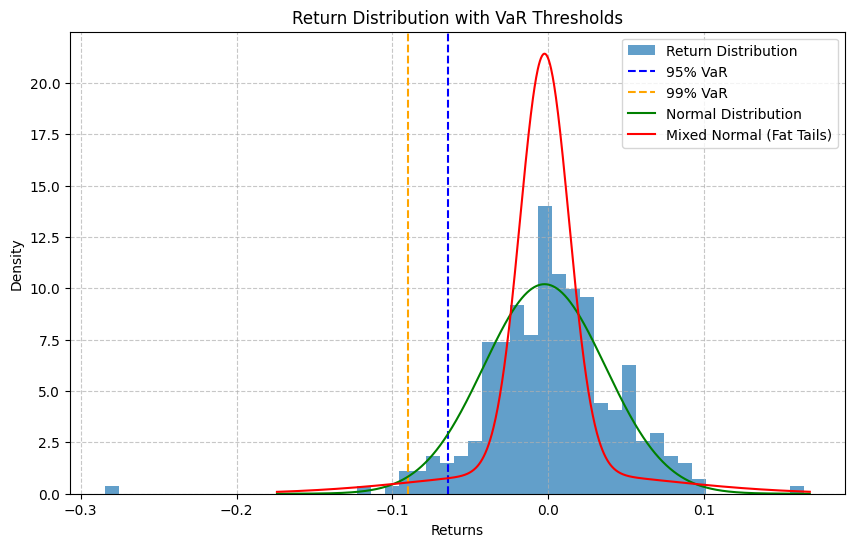

In [467]:
import matplotlib.pyplot as plt
import numpy as np

def plot_return_distribution_with_var(returns, var95, var99):
    plt.figure(figsize=(10, 6))
    
    # Plot histogram of returns
    plt.hist(returns, bins=50, density=True, alpha=0.7, label='Return Distribution')
    
    # Plot 95% and 99% VaR levels
    plt.axvline(x=var95, color='blue', linestyle='--', label='95% VaR')
    plt.axvline(x=var99, color='orange', linestyle='--', label='99% VaR')
    plt.plot(x_vals, norm_dist, label="Normal Distribution", color='green')
    plt.plot(x_vals, fat_tails, label="Mixed Normal (Fat Tails)", color='red')
    

    plt.title('Return Distribution with VaR Thresholds')
    plt.xlabel('Returns')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

# Example usage
plot_return_distribution_with_var(ret, np.percentile(ret, 5), np.percentile(ret, 1))


In [468]:
df_stocks = pd.read_csv('CASE_2.csv')


In [469]:
import pandas as pd
# reads the data



# reducding the sample by foccusing on a few stocks of interest
df_stocks = df_stocks[df_stocks['Symbol'].isin(['EQNR','MPCC','NAS'])]

# we capture the ISIN-ticker combinations for later use, to associate stocks with tickers
# We need to use the ISIN in what's follows, because ticker is not a reliable identifier
df_isin_symbol =  df_stocks[['ISIN','Symbol']].drop_duplicates()

# choosing relevant columns
df_stocks = df_stocks[['Symbol', 'Date', 'lnDeltaP', 
                'lnDeltaOSEBX',  'SMB', 'HML', 
                'LIQ', 'MOM', 'NOWA_DayLnrate']]

# defines the indicies
df_stocks['Date'] = pd.to_datetime(df_stocks['Date'])
df_stocks = df_stocks.set_index(['Symbol', 'Date'])

# making sure the index is unique and remove nans
df_stocks = df_stocks[~df_stocks.index.duplicated(keep='first')]
df_stocks = df_stocks.dropna(subset=['SMB'])

# Define excess return of stocks and market index
df_stocks['lnDeltaP_rf'] = (df_stocks['lnDeltaP'] 
                                - df_stocks['NOWA_DayLnrate'])
df_stocks['lnDeltaOSEBX_rf'] = (df_stocks['lnDeltaOSEBX'] 
                                - df_stocks['NOWA_DayLnrate'])

# Creating weekly observations
df_stocks_w = df_stocks.groupby('Symbol').resample('W', level='Date').sum()
df_stocks_w

lnDeltaP  lnDeltaOSEBX       SMB       HML       LIQ  \
Symbol Date                                                               
EQNR   2018-02-04 -0.038789     -0.016245  0.016868 -0.031242  0.035416   
       2018-02-11 -0.022192     -0.027950  0.033779  0.026280  0.002070   
       2018-02-18  0.016373      0.028006  0.018685  0.011425 -0.022803   
       2018-02-25  0.030582      0.015407 -0.022377  0.004599 -0.005271   
       2018-03-04 -0.034006     -0.035264  0.000178 -0.037089  0.013908   
...                     ...           ...       ...       ...       ...   
NAS    2024-09-08 -0.052363     -0.037876  0.015250  0.000000  0.016956   
       2024-09-15  0.072476      0.015373 -0.019021  0.000000 -0.002736   
       2024-09-22  0.064262      0.000014 -0.008935  0.000000 -0.029921   
       2024-09-29  0.059599     -0.000355 -0.006304  0.000000 -0.013839   
       2024-10-06  0.013204      0.006638 -0.008342  0.000000  0.001604   

                        MOM  NOWA_DayLnrate  lnDeltaP_rf  lnDeltaOSEBX_rf  
Symbol Date                                                                
EQNR   2018-02-04  0.023751        0.000109    -0.038898        -0.016353  
       2018-02-11 -0.056335        0.000108    -0.022300        -0.028058  
       2018-02-18 -0.048256        0.000110     0.016263         0.027897  
       2018-02-25 -0.002650        0.000110     0.030471         0.015296  
       2018-03-04  0.006789        0.000110    -0.034116        -0.035374  
...                     ...             ...          ...              ...  
NAS    2024-09-08  0.026948        0.000978    -0.053341        -0.038854  
       2024-09-15 -0.006592        0.000978     0.071497         0.014394  
       2024-09-22  0.009926        0.000978     0.063284        -0.000964  
       2024-09-29  0.027462        0.000978     0.058621        -0.001333  
       2024-10-06 -0.012684        0.000196     0.013008         0.006442  

[1047 rows x 9 columns]

In [470]:
import statsmodels.api as sm

# Filter the DataFrame for Symbol = 'EQNR'
df_reg = df_stocks_w.loc['EQNR']

# Define the independent variables (features) and dependent variable (target)
X = df_reg[['lnDeltaOSEBX_rf', 'SMB', 'HML', 'LIQ', 'MOM']]
y = df_reg['lnDeltaP_rf']

# Add a constant to the independent variables for the intercept
X = sm.add_constant(X)

# Perform the regression
model = sm.OLS(y, X).fit()

# Display the summary of the regression
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            lnDeltaP_rf   R-squared:                       0.607
Model:                            OLS   Adj. R-squared:                  0.602
Method:                 Least Squares   F-statistic:                     106.1
Date:                Fri, 22 Nov 2024   Prob (F-statistic):           1.90e-67
Time:                        10:30:24   Log-Likelihood:                 787.82
No. Observations:                 349   AIC:                            -1564.
Df Residuals:                     343   BIC:                            -1541.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0002      0.001     

In [471]:
import statsmodels.api as sm

# Filter the DataFrame for Symbol = 'EQNR'
df_reg = df_stocks_w.loc['MPCC']

# Define the independent variables (features) and dependent variable (target)
X = df_reg[['lnDeltaOSEBX_rf', 'SMB', 'HML', 'LIQ', 'MOM']]
y = df_reg['lnDeltaP_rf']

# Add a constant to the independent variables for the intercept
X = sm.add_constant(X)

# Perform the regression
model = sm.OLS(y, X).fit()

# Display the summary of the regression
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            lnDeltaP_rf   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     7.356
Date:                Fri, 22 Nov 2024   Prob (F-statistic):           1.44e-06
Time:                        10:30:24   Log-Likelihood:                 352.16
No. Observations:                 349   AIC:                            -692.3
Df Residuals:                     343   BIC:                            -669.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0001      0.005     

In [472]:
import statsmodels.api as sm

# Filter the DataFrame for Symbol = 'EQNR'
df_reg = df_stocks_w.loc['NAS']

# Define the independent variables (features) and dependent variable (target)
X = df_reg[['lnDeltaOSEBX_rf', 'SMB', 'HML', 'LIQ', 'MOM']]
y = df_reg['lnDeltaP_rf']

# Add a constant to the independent variables for the intercept
X = sm.add_constant(X)

# Perform the regression
model = sm.OLS(y, X).fit()

# Display the summary of the regression
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            lnDeltaP_rf   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     6.775
Date:                Fri, 22 Nov 2024   Prob (F-statistic):           4.85e-06
Time:                        10:30:24   Log-Likelihood:                 245.02
No. Observations:                 349   AIC:                            -478.0
Df Residuals:                     343   BIC:                            -454.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0187      0.007     

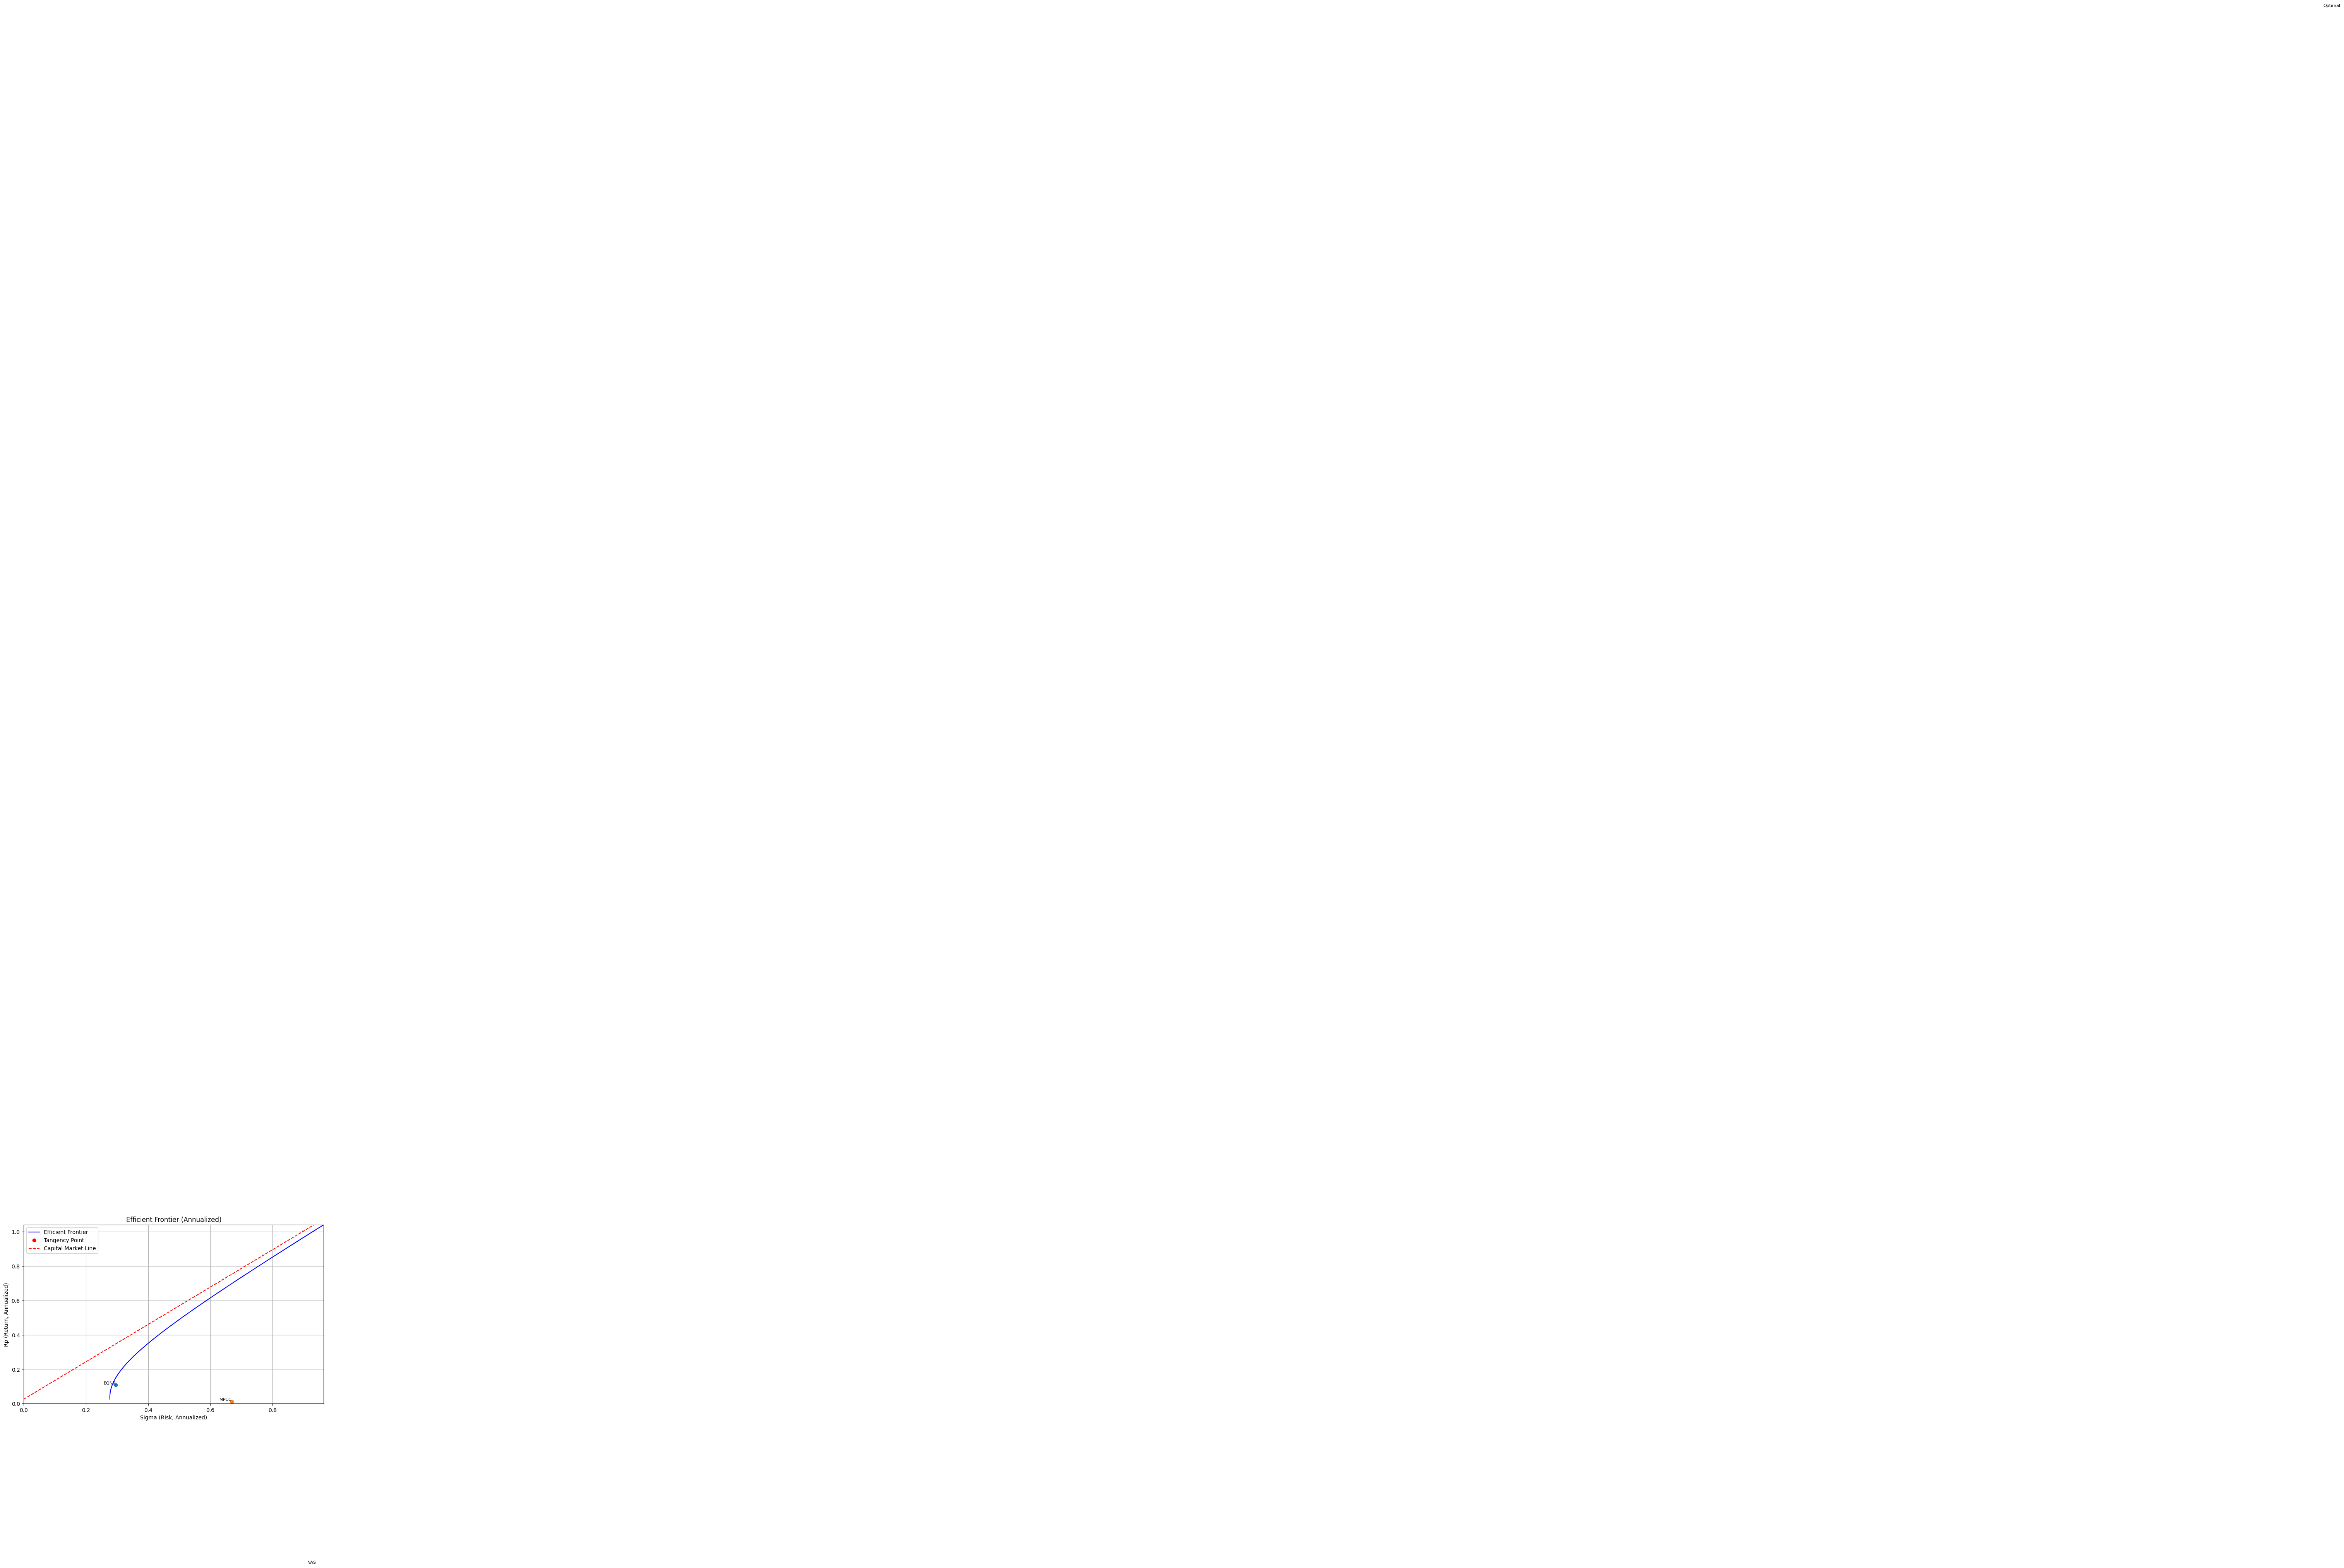

In [473]:
expected = X_df.mean()*52
std = X_df.std()*52**0.5
MAX_AXIS = 1

for series in expected.index:
        ax.scatter(std[series], expected[series], label=series)
        ax.text(std[series], expected[series], series, fontsize=8, ha='right', va='bottom')

fig

In [474]:


# inserting the portfolio into a data frame for display
d = {}
for i in range(len(opt_port)):
    d[X_df.columns[i]] = [f"{np.round(opt_port[i][0]*100,0)}%"]

print("Hence the optimal portfolio in this case is")
pd.DataFrame(d)

Hence the optimal portfolio in this case is


,EQNR,MPCC,NAS
0,874.0%,-7.0%,-768.0%


In [475]:
import os

os.makedirs('output', exist_ok=True)
pd.to_pickle(df,'output/factors.df')

In [476]:
df = pd.read_csv('CASE_2.csv')


In [477]:
import pandas as pd


df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
df_weekly = df.resample('W').sum()
df_weekly = df_weekly[['SMB', 'HML', 'LIQ', 'MOM']].dropna()
df = df[['SMB', 'HML', 'LIQ', 'MOM']].dropna()
means = df_weekly.mean()*52
std = df_weekly.std()*52**0.5
print(std)
print(means)
df_weekly

SMB    0.431253
HML    0.556740
LIQ    0.478737
MOM    0.673585
dtype: float64
SMB    0.099726
HML    0.345639
LIQ   -0.029990
MOM    0.579518
dtype: float64


,SMB,HML,LIQ,MOM
Date,,,,
2018-02-04,0.050603,-0.093727,0.106247,0.071254
2018-02-11,0.101338,0.078841,0.006210,-0.169005
2018-02-18,0.056055,0.034274,-0.068410,-0.144768
2018-02-25,-0.067130,0.013797,-0.015812,-0.007950
2018-03-04,0.000532,-0.111268,0.041725,0.020367
...,...,...,...,...
2024-10-20,0.000000,0.000000,0.000000,0.000000
2024-10-27,0.000000,0.000000,0.000000,0.000000
2024-11-03,0.000000,0.000000,0.000000,0.000000


In [478]:
df_weekly.to_csv("df_weekly_full.csv", index=False)



PermissionError: [Errno 13] Permission denied: 'df_weekly_full.csv'

In [ ]:
print(df_weekly)


                 SMB       HML       LIQ       MOM
Date                                              
2018-02-04  0.050603 -0.093727  0.106247  0.071254
2018-02-11  0.101338  0.078841  0.006210 -0.169005
2018-02-18  0.056055  0.034274 -0.068410 -0.144768
2018-02-25 -0.067130  0.013797 -0.015812 -0.007950
2018-03-04  0.000532 -0.111268  0.041725  0.020367
...              ...       ...       ...       ...
2024-10-20  0.000000  0.000000  0.000000  0.000000
2024-10-27  0.000000  0.000000  0.000000  0.000000
2024-11-03  0.000000  0.000000  0.000000  0.000000
2024-11-10  0.000000  0.000000  0.000000  0.000000
2024-11-17  0.000000  0.000000  0.000000  0.000000

[355 rows x 4 columns]


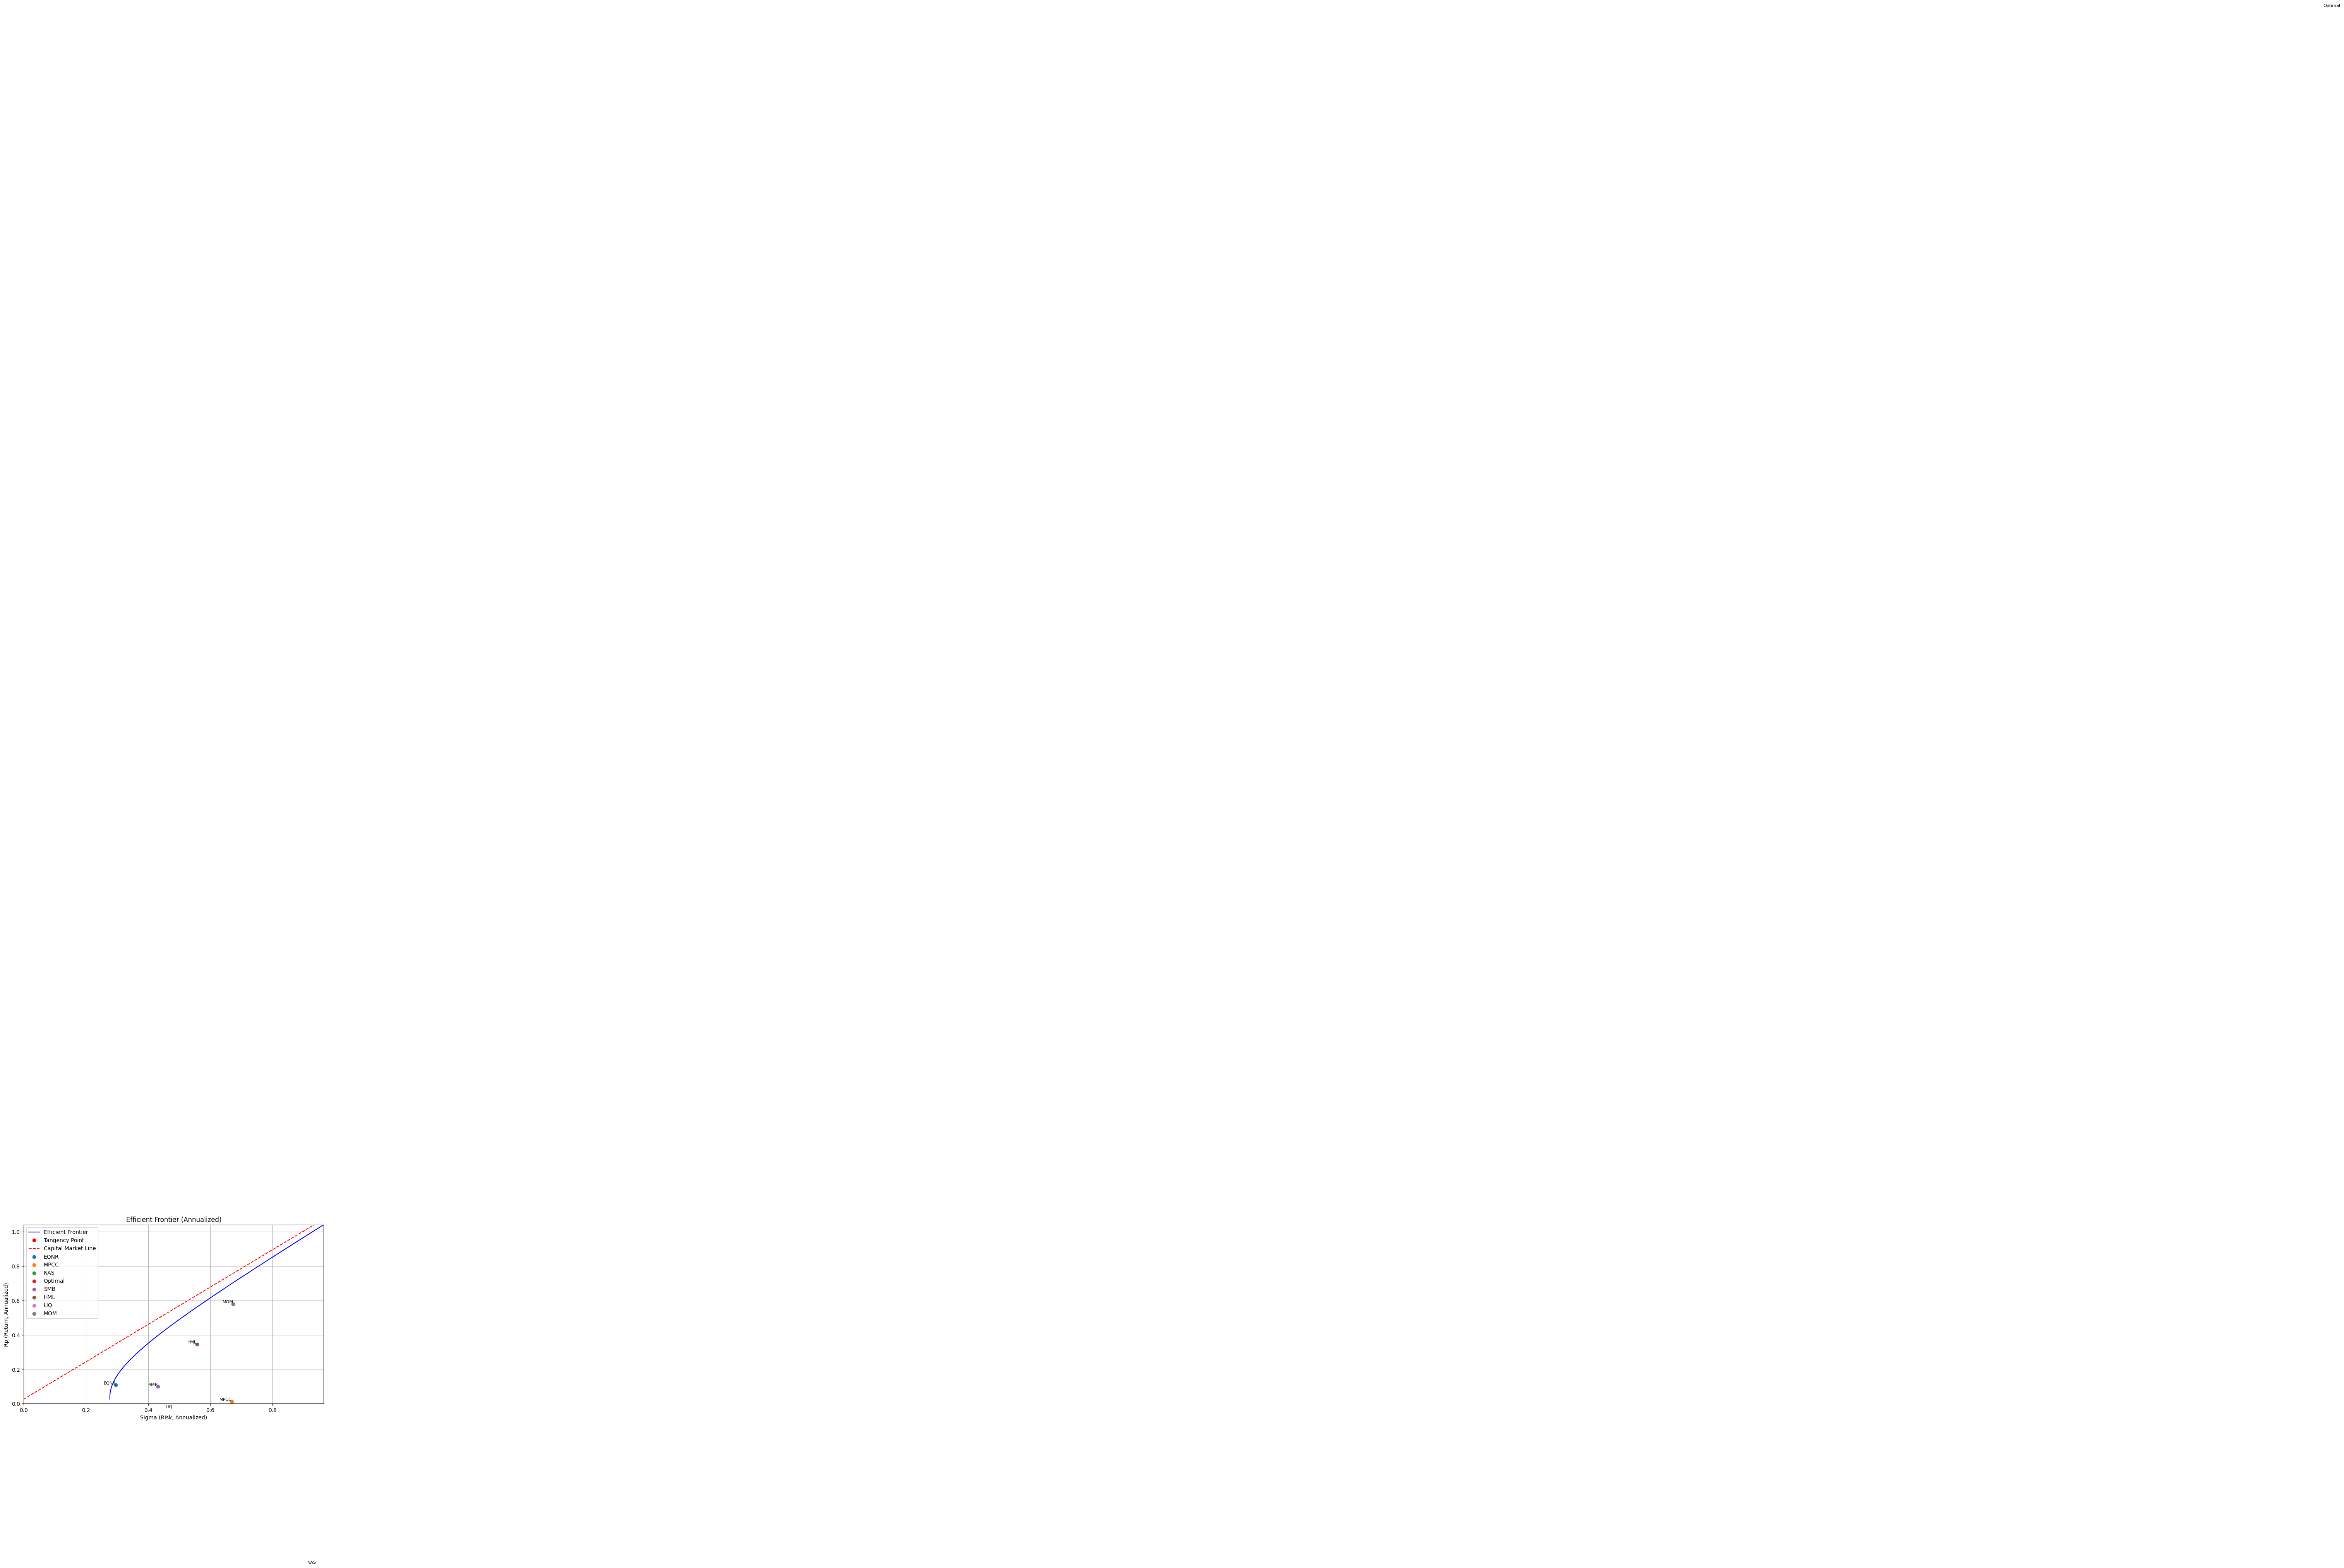

In [ ]:
for series in means.index:
        ax.scatter(std[series], means[series], label=series)
        ax.text(std[series], means[series], series, fontsize=8, ha='right', va='bottom')
ax.legend()
fig